In [1]:
import librosa
import os
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
from utils import *
import soundfile as sf
from collections import defaultdict
from python_speech_features import logfbank,mfcc
import numpy as np
from sklearn.manifold import TSNE
from CQCC.cqcc import cqcc
from transformers import AutoFeatureExtractor, WavLMForXVector
import torch

In [2]:
metadata_train_path="../Data/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.train.trn.txt"
metadata_dev_path="../Data/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.dev.trl.txt"
metadata_eval_path="../Data/PA/ASVspoof2019_PA_cm_protocols/ASVspoof2019.PA.cm.eval.trl.txt"

audio_train_path="../Data/PA/ASVspoof2019_PA_train/flac/"
audio_dev_path="../Data/PA/ASVspoof2019_PA_dev/flac/"
audio_eval_path="../Data/PA/ASVspoof2019_PA_eval/flac/"

In [3]:
total_train_files = len(os.listdir(audio_train_path))
total_dev_files = len(os.listdir(audio_dev_path))
total_eval_files = len(os.listdir(audio_eval_path))
print("total_train_files : ",total_train_files)
print("total_dev_files : ",total_dev_files)
print("total_eval_files : ",total_eval_files)

total_train_files :  54000
total_dev_files :  33534
total_eval_files :  153522


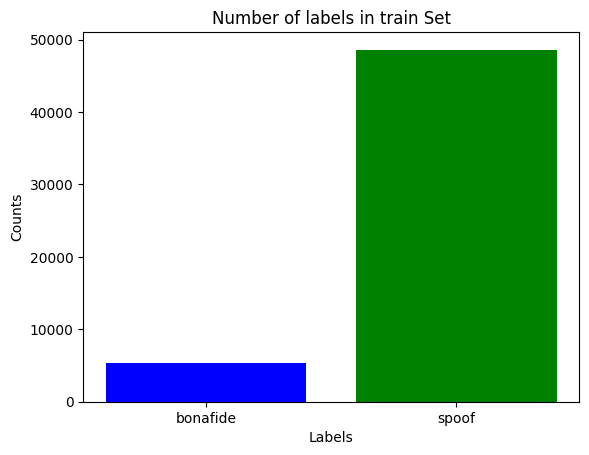

In [4]:
plot_label_counts(metadata_train_path,"Number of labels in train Set")

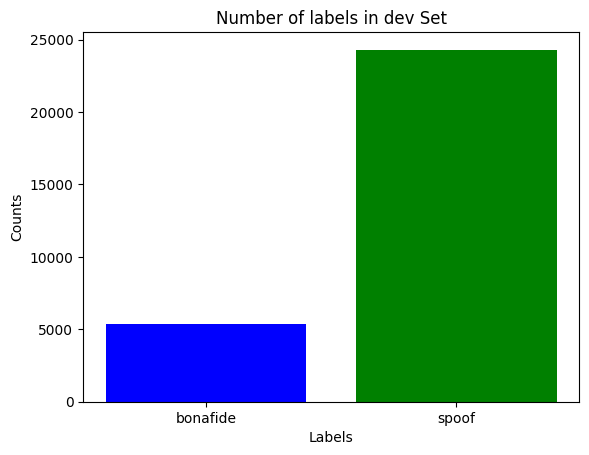

In [5]:
plot_label_counts(metadata_dev_path,"Number of labels in dev Set")

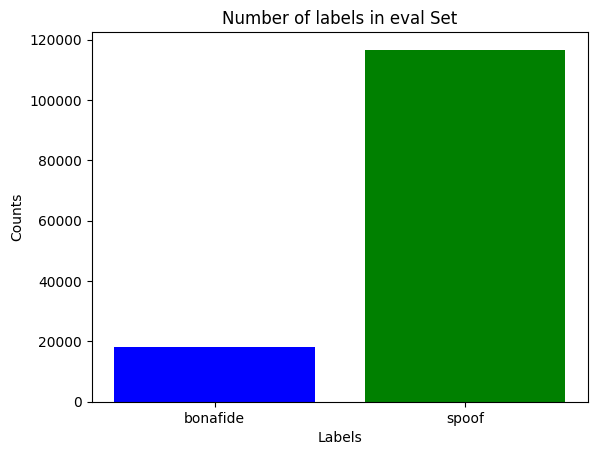

In [6]:
plot_label_counts(metadata_eval_path, "Number of labels in eval Set")

In [7]:
train=create_audio_dataset(metadata_train_path,audio_train_path,log=True,log_frequency=20)

Progress: 5.00%


KeyboardInterrupt: 

In [12]:
train.to_csv('../Data/PA_CSV/train_data.csv',index=False)

In [10]:
train.columns

Index(['speaker_id', 'filename', 'system_id', 'class_name', 'filepath',
       'target', 'length'],
      dtype='object')

In [19]:
train.system_id.value_counts()

system_id
AA    7144
AB    7144
AC    7144
-     5400
CA    5200
CB    5200
CC    5200
BA    3856
BB    3856
BC    3856
Name: count, dtype: int64

In [9]:
dev=create_audio_dataset(metadata_dev_path,audio_dev_path,log=True,log_frequency=40)

Progress: 2.50%
Progress: 5.00%
Progress: 7.50%
Progress: 10.00%
Progress: 12.49%
Progress: 14.99%
Progress: 17.49%
Progress: 19.99%
Progress: 22.49%
Progress: 24.99%
Progress: 27.49%
Progress: 29.99%
Progress: 32.49%
Progress: 34.99%
Progress: 37.48%
Progress: 39.98%
Progress: 42.48%
Progress: 44.98%
Progress: 47.48%
Progress: 49.98%
Progress: 52.48%
Progress: 54.98%
Progress: 57.48%
Progress: 59.97%
Progress: 62.47%
Progress: 64.97%
Progress: 67.47%
Progress: 69.97%
Progress: 72.47%
Progress: 74.97%
Progress: 77.47%
Progress: 79.97%
Progress: 82.47%
Progress: 84.96%
Progress: 87.46%


In [13]:
dev.to_csv('../Data/PA_CSV/dev_data.csv',index=False)

In [11]:
eval=create_audio_dataset(metadata_eval_path,audio_eval_path,log=True,log_frequency=60)

Progress: 1.67%
Progress: 3.33%
Progress: 5.00%
Progress: 6.66%
Progress: 8.33%
Progress: 10.00%
Progress: 11.66%
Progress: 13.33%
Progress: 15.00%
Progress: 16.66%
Progress: 18.33%
Progress: 19.99%
Progress: 21.66%
Progress: 23.33%
Progress: 24.99%
Progress: 26.66%
Progress: 28.33%
Progress: 29.99%
Progress: 31.66%
Progress: 33.32%
Progress: 34.99%
Progress: 36.66%
Progress: 38.32%
Progress: 39.99%
Progress: 41.66%
Progress: 43.32%
Progress: 44.99%
Progress: 46.65%
Progress: 48.32%
Progress: 49.99%
Progress: 51.65%
Progress: 53.32%
Progress: 54.98%
Progress: 56.65%
Progress: 58.32%
Progress: 59.98%
Progress: 61.65%
Progress: 63.32%
Progress: 64.98%
Progress: 66.65%
Progress: 68.31%
Progress: 69.98%
Progress: 71.65%
Progress: 73.31%
Progress: 74.98%
Progress: 76.65%
Progress: 78.31%
Progress: 79.98%
Progress: 81.64%
Progress: 83.31%
Progress: 84.98%
Progress: 86.64%


In [14]:
eval.to_csv('../Data/PA_CSV/eval_data.csv',index=False)

In [15]:
eval.columns

Index(['speaker_id', 'filename', 'system_id', 'class_name', 'filepath',
       'target', 'length'],
      dtype='object')

In [20]:
data=pd.concat([eval,dev,train],axis=0)

In [21]:
data.duplicated(subset=data.columns.difference(['filepath'])).sum()

0

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218430 entries, 0 to 53999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   speaker_id  218430 non-null  object 
 1   filename    218430 non-null  object 
 2   system_id   218430 non-null  object 
 3   class_name  218430 non-null  object 
 4   filepath    218430 non-null  object 
 5   target      218430 non-null  int32  
 6   length      218430 non-null  float64
dtypes: float64(1), int32(1), object(5)
memory usage: 12.5+ MB


In [23]:
data.describe()

,target,length
count,218430.000000,218430.000000
mean,0.867738,4.281001
std,0.338776,1.196428
min,0.000000,1.456937
25%,1.000000,3.418438
50%,1.000000,4.170906
75%,1.000000,4.976625
max,1.000000,10.318687


In [24]:
data.head()

,speaker_id,filename,system_id,class_name,filepath,target,length
0,PA_0016,PA_E_0000001,-,bonafide,../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000...,0,2.319313
1,PA_0029,PA_E_0000002,BB,spoof,../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000...,1,3.624875
2,PA_0044,PA_E_0000003,BA,spoof,../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000...,1,3.591312
3,PA_0019,PA_E_0000004,CC,spoof,../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000...,1,2.814875
4,PA_0021,PA_E_0000005,AB,spoof,../Data/PA/ASVspoof2019_PA_eval/flac/PA_E_0000...,1,4.043188


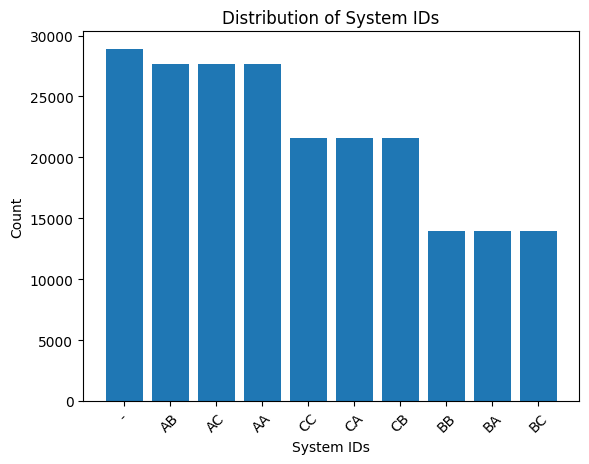

In [25]:
system_counts = data['system_id'].value_counts()
plt.bar(system_counts.index, system_counts.values)
plt.xlabel('System IDs')
plt.ylabel('Count')
plt.title('Distribution of System IDs')
plt.xticks(rotation=45)
plt.show()

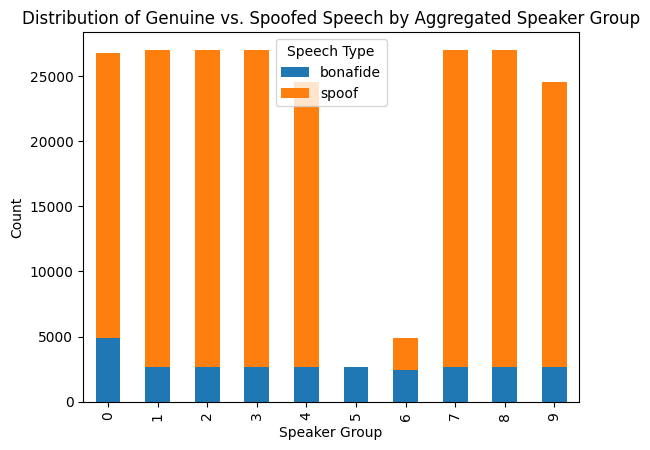

In [26]:
speaker_counts = data.groupby(['speaker_id', 'class_name']).size().unstack(fill_value=0)
data['speaker_group'] = data['speaker_id'].str[5] 
speaker_group_counts = data.groupby(['speaker_group', 'class_name']).size().unstack(fill_value=0)
speaker_group_counts.plot(kind='bar', stacked=True)
plt.xlabel('Speaker Group')
plt.ylabel('Count')
plt.title('Distribution of Genuine vs. Spoofed Speech by Aggregated Speaker Group')
plt.legend(title='Speech Type')
plt.show()

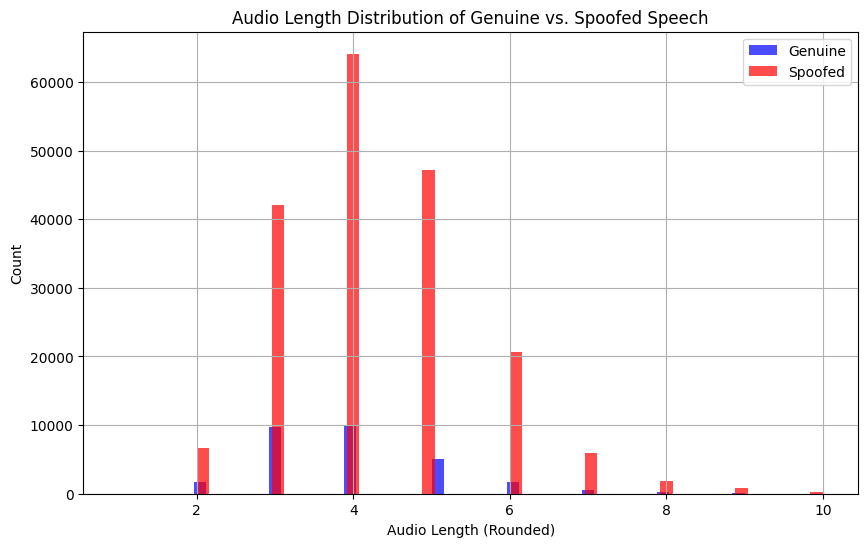

In [27]:
data['length_rounded'] = data['length'].apply(lambda x: round(x))
plt.figure(figsize=(10, 6)) 
plt.hist(data[data['class_name'] == 'bonafide']['length_rounded'], bins=50, alpha=0.7, color='blue', label='Genuine')
plt.hist(data[data['class_name'] == 'spoof']['length_rounded'], bins=50, alpha=0.7, color='red', label='Spoofed')
plt.xlabel('Audio Length (Rounded)')
plt.ylabel('Count')
plt.title('Audio Length Distribution of Genuine vs. Spoofed Speech')
plt.legend()
plt.grid(True)  # Add grid lines for better readability
plt.show()

In [28]:
data.to_csv('../Data/PA_CSV/data.csv',index=False)